# MNIST Prediction with Artificial Neural Network

- MNIST dataset: is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
- Goal: build a simple artificial neural network to predict the digit in the images.

In [92]:
# for linear algebra
import numpy as np

# for plotting data, loss, accuracy
import matplotlib.pyplot as plt

# for data loading
import keras
from keras import layers  # only used in 4.2

# for type hinting
from typing import Optional

# show progress bar
from tqdm import tqdm

## 1. Utility Functions

### 1.1. Plotting Functions

In [93]:
def plot_data(
    X: np.ndarray, y: np.ndarray, y_proba: Optional[np.ndarray] = None
) -> None:
    nrows, ncols = 2, 4
    _, axes = plt.subplots(nrows, ncols, figsize=(8, 4))

    len_x = X.shape[0]
    for idx in range(nrows * ncols):
        ax = axes[idx // ncols, idx % ncols]

        img_idx = np.random.randint(0, len_x)

        ax.imshow(X[img_idx], cmap="gray")
        ax.set(xticks=[], yticks=[])

        true_label = f"True: {y[img_idx]}"

        if y_proba is not None:
            pred_label = f"Pred: {y_proba[img_idx]}"

        img_title = true_label if y_proba is None else f"{true_label}\n{pred_label}"
        ax.set_xlabel(img_title)

    plt.tight_layout()
    plt.show()

### 1.2. Activation Functions

- Sigmoid function: $\sigma(z) = \frac{1}{1 + e^{-z}}$
- Derivative of sigmoid function: $\sigma'(z) = \sigma(z)(1 - \sigma(z))$

- ReLU function: $f(z) = \max(0, z)$
- Derivative of ReLU function: $f'(z) = 0$ if $z < 0$ and $f'(z) = 1$ if $z \geq 0$

- Tanh function: $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$
- Derivative of tanh function: $\tanh'(z) = 1 - \tanh^2(z)$

- Softmax function: $S(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}$ for $j = 1, 2, \ldots, K$
- Derivative of softmax function: $\frac{\partial S(z)_j}{\partial z_i} = S(z)_j(\delta_{ij} - S(z)_i)$

In [94]:
class Activation:
    def __init__(self, act: str = None) -> None:
        if act is None:
            self.act = "relu"
        else:
            self.act = act

    def linear(self, x: np.ndarray) -> np.ndarray:
        return x

    def d_linear(self, x: np.ndarray) -> np.ndarray:
        return np.ones(x.shape)

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x: np.ndarray) -> np.ndarray:
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x: np.ndarray) -> np.ndarray:
        return np.tanh(x)

    def d_tanh(self, x: np.ndarray) -> np.ndarray:
        return 1 - self.tanh(x) ** 2

    def reLU(self, x: np.ndarray) -> np.ndarray:
        return x * (x > 0)

    def d_reLU(self, x: np.ndarray) -> np.ndarray:
        return (x > 0) * np.ones(x.shape)

    def softmax(self, x: np.ndarray) -> np.ndarray:
        z = x - np.max(x, axis=-1, keepdims=True)
        numerator = np.exp(z)
        denominator = np.sum(numerator, axis=-1, keepdims=True)
        softmax = numerator / denominator
        return softmax

    def d_softmax(self, x: np.ndarray) -> np.ndarray:
        if len(x.shape) == 1:
            x = np.array(x).reshape(1, -1)
        else:
            x = np.array(x)
        m, d = x.shape
        a = self.softmax(x)
        tensor1 = np.einsum("ij,ik->ijk", a, a)
        tensor2 = np.einsum("ij,jk->ijk", a, np.eye(d, d))
        return tensor2 - tensor1

    def get_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act == "linear":
            return self.linear(X)
        elif self.act == "sigmoid":
            return self.sigmoid(X)
        elif self.act == "tanh":
            return self.tanh(X)
        elif self.act == "reLU":
            return self.reLU(X)
        elif self.act == "softmax":
            return self.softmax(X)
        else:
            raise ValueError("Activation function not recognized")

    def get_d_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act == "linear":
            return self.d_linear(X)
        elif self.act == "sigmoid":
            return self.d_sigmoid(X)
        elif self.act == "tanh":
            return self.d_tanh(X)
        elif self.act == "reLU":
            return self.d_reLU(X)
        elif self.act == "softmax":
            return self.d_softmax(X)
        else:
            raise ValueError("Activation function not recognized")

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        z = self.get_activation(X)
        return z

    def backpropagation(self, dZ: np.ndarray) -> np.ndarray:
        dA = dZ * self.get_d_activation(self.X)
        if self.activation_type == "softmax":
            dX = np.einsum("ijk,ik->ij", dA, dZ)
        else:
            dX = dA * dZ
        return dX

### 1.3. Weight Initialization Class

- Zeros initialization: $w = np.zeros(shape)$
- Ones initialization: $w = np.ones(shape)$
- Random initialization: $w = np.random.randn(shape)$
- Random uniform initialization: $w = np.random.uniform(size=shape)$

In [95]:
class WeightInitializer:
    def __init__(self, shape, init: str = None, seed: int = None) -> None:
        """
        :param shape: shape of the weight matrix
        :param init: type of initialization (available initializations: zeros, ones, random, random_uniform)
        :param seed: seed for random initialization
        """
        self.shape = shape

        if init is None:
            self.init = "random"
        else:
            self.init = init

        if seed is None:
            self.seed = 69
        else:
            self.seed = seed

    def zeros(self) -> np.ndarray:
        return np.zeros(self.shape)

    def ones(self) -> np.ndarray:
        return np.ones(self.shape)

    def random(self) -> np.ndarray:
        np.random.seed(self.seed)
        return np.random.randn(*self.shape)

    def random_uniform(self) -> np.ndarray:
        np.random.seed(self.seed)
        return np.random.uniform(size=self.shape)

    def get_initializer(self) -> np.ndarray:
        if self.init == "zeros":
            return self.zeros()
        elif self.init == "ones":
            return self.ones()
        elif self.init == "random":
            return self.random()
        elif self.init == "random_uniform":
            return self.random_uniform()
        else:
            raise ValueError(
                "Valid initializations are: zeros, ones, random, random_uniform"
            )

### 1.4.  Optimizers Class

- Gradient Descent Optimizer: $w = w - \alpha \nabla_w L(w)$
- Stochastic Gradient Descent Optimizer: $w = w - \alpha \nabla_w L(w)$
- RMSprop Optimizer: $v = \beta v + (1 - \beta) \nabla_w L(w) \odot \nabla_w L(w)$ and $w = w - \alpha \frac{\nabla_w L(w)}{\sqrt{v + \epsilon}}$
- Adam Optimizer: $m = \beta_1 m + (1 - \beta_1) \nabla_w L(w)$, $v = \beta_2 v + (1 - \beta_2) \nabla_w L(w) \odot \nabla_w L(w)$, $m_{\text{corrected}} = \frac{m}{1 - \beta_1^t}$, $v_{\text{corrected}} = \frac{v}{1 - \beta_2^t}$, and $w = w - \alpha \frac{m_{\text{corrected}}}{\sqrt{v_{\text{corrected}} + \epsilon}}$

In [96]:
class Optimizer:
    def __init__(
        self,
        op_type: str = None,
        shape_W: tuple = None,
        shape_b: tuple = None,
        m1: float = 0.9,
        m2: float = 0.999,
        epsilon: int = 1e-8,
    ) -> None:
        """
        :param op_type: type of optimizer (available optimizers: GD, SGD, RMSProp, Adam)
        :param shape_W: shape of the weight matrix
        :param shape_b: shape of the bias matrix
        :param m1: hyperparameter >= 0 that accelerates gradient descent in the relevant direction and dampens oscillations. Used in RMSprop
        :param m2: hyperparameter for adam only
        :param epsilon: parameter used in adam and RMSprop to prevent division by zero error
        """
        if op_type is None:
            self.op_type = "adam"
        else:
            self.op_type = op_type

        self.m1 = m1
        self.m2 = m2
        self.epsilon = epsilon

        self.vdW = np.zeros(shape_W)
        self.vdb = np.zeros(shape_b)

        self.SdW = np.zeros(shape_W)
        self.Sdb = np.zeros(shape_b)

    def GD(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        return dW, db

    def SGD(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        self.vdW = self.momentum1 * self.vdW + (1 - self.momentum1) * dW
        self.vdb = self.momentum1 * self.vdb + (1 - self.momentum1) * db

        return self.vdW, self.vdb

    def RMSProp(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        self.SdW = self.momentum2 * self.SdW + (1 - self.momentum2) * (dW**2)
        self.Sdb = self.momentum2 * self.Sdb + (1 - self.momentum2) * (db**2)

        den_W = np.sqrt(self.SdW) + self.epsilon
        den_b = np.sqrt(self.Sdb) + self.epsilon

        return dW / den_W, db / den_b

    def Adam(self, dW: np.ndarray, db: np.ndarray, k: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        # momentum
        self.vdW = self.momentum1 * self.vdW + (1 - self.momentum1) * dW
        self.vdb = self.momentum1 * self.vdb + (1 - self.momentum1) * db

        # rmsprop
        self.SdW = self.momentum2 * self.SdW + (1 - self.momentum2) * (dW**2)
        self.Sdb = self.momentum2 * self.Sdb + (1 - self.momentum2) * (db**2)

        # correction
        if k > 1:
            vdW_h = self.vdW / (1 - (self.momentum1**k))
            vdb_h = self.vdb / (1 - (self.momentum1**k))
            SdW_h = self.SdW / (1 - (self.momentum2**k))
            Sdb_h = self.Sdb / (1 - (self.momentum2**k))
        else:
            vdW_h = self.vdW
            vdb_h = self.vdb
            SdW_h = self.SdW
            Sdb_h = self.Sdb

        den_W = np.sqrt(SdW_h) + self.epsilon
        den_b = np.sqrt(Sdb_h) + self.epsilon

        return vdW_h / den_W, vdb_h / den_b

    def get_optimizer(self, dW: np.ndarray, db: np.ndarray, k: int) -> tuple:
        if self.op_type == "GD":
            return self.GD(dW, db, k)
        elif self.op_type == "SGD":
            return self.SGD(dW, db, k)
        elif self.op_type == "RMSProp":
            return self.RMSProp(dW, db, k)
        elif self.op_type == "Adam":
            return self.Adam(dW, db, k)
        else:
            raise ValueError("Valid optiomizers are GD, SGD, RMSProp, Adam")

## 2. Load Data

- Load the MNIST dataset from the `keras.datasets` module.

In [97]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

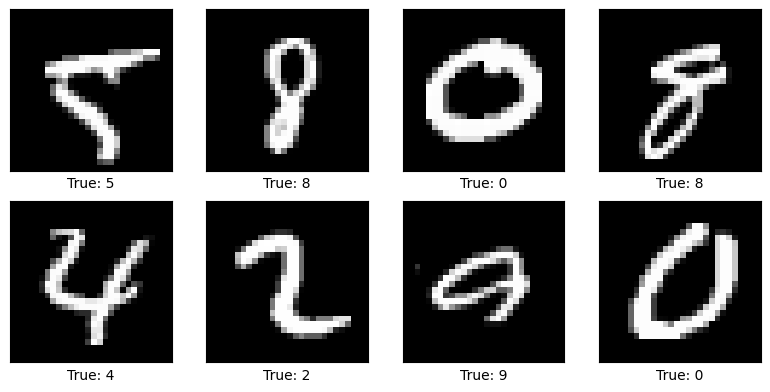

In [98]:
plot_data(X_train, y_train)

## 3. Image Preprocessing

- Normalize the images by dividing each pixel by 255.
- Add channel dimension to the images.
- Convert y to matrix form with shape (m, 10) where m is the number of samples.

In [99]:
# Convert to float32 and scale to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [100]:
# Add channel dimension
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [101]:
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [102]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [103]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (60000, 10)
y_test shape: (10000, 10)


## 4. Artificial Neural Network

### 4.1. With Convolutional Neural Network

#### 4.1.1. Feature Extraction

In [104]:
class Conv2d:
    def __init__(self, inp: np.ndarray, kernel_size: int) -> None:
        self.inp = inp
        self.kernel = np.random.randn(kernel_size, kernel_size)

        height, width = inp.shape
        self.out = np.zeros((height - kernel_size + 1, width - kernel_size + 1))

    def getROI(self):
        # ROI: Region of Interest
        for row in range(self.out.shape[0]):
            for col in range(self.out.shape[1]):
                yield row, col, self.inp[
                    row : row + self.kernel.shape[0], col : col + self.kernel.shape[1]
                ]

    def operation(self) -> np.ndarray:
        for row, col, roi in self.getROI():
            self.out[row, col] += np.sum(roi * self.kernel)

        return self.out

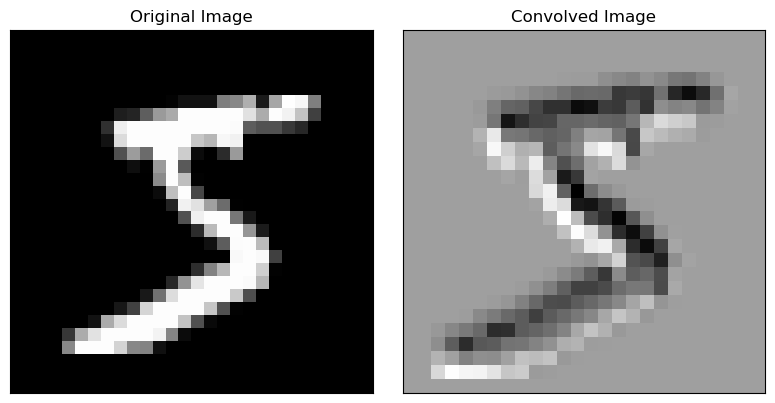

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

img = X_train[0, :, :, 0]
conv = Conv2d(img, 3)

axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original Image")
axes[0].set(xticks=[], yticks=[])

axes[1].imshow(conv.operation(), cmap="gray")
axes[1].set_title("Convolved Image")
axes[1].set(xticks=[], yticks=[])

plt.tight_layout()
plt.show()

#### 4.1.2. Dense Layer

THis class implements the operations:
- Forward: 
    1. $Z = XW + B^T$
    2. $A = f(Z)$
- Backward: $dX = dZ W^T$, $dW = X^T dZ$, and $dB = \sum_{i=1}^{m} dZ_i$

In [119]:
class Dense:
    def __init__(
        self,
        neurons: int,
        act: str = None,
        use_bias: bool = True,
        weight_type: str = None,
        weight_regularizer: tuple = None,
        seed: int = None,
        inp_dim: int = None,
    ) -> None:
        """
        :param neurons: Number of neurons in the layer
        :param act: Activation function to use
        :param use_bias: Whether to use bias
        :param weight_type: Type of weight initialization
        :param weight_regularizer: Regularization term for the weights
        :param seed: Seed for random initialization
        :param inp_dim: Input dimension for the layer
        """
        self.neurons = neurons
        self.act = Activation(act)
        self.use_bias = use_bias
        self.weight_initializer = weight_type

        if weight_regularizer is not None:
            self.weight_regularizer = weight_regularizer
        else:
            self.weight_regularizer = ("L2", 0)

        self.seed = seed
        self.inp_dim = inp_dim

    def initialize(self, hl: int, op_type: str) -> None:
        """
        :param hl: Number of neurons in the previous layer
        :param op_type: Type of optimizer to use (GD, SGD, RMSProp, Adam)
        """
        shape_W = (hl, self.neurons)
        shape_b = (self.neurons, 1)
        initializer = WeightInitializer(
            shape=shape_W, initializer_type=self.weight_initializer_type, seed=self.seed
        )
        self.W = initializer.get_initializer()
        self.b = np.zeros(shape_b)

        self.optimizer = Optimizer(op_type=op_type, shape_W=shape_W, shape_b=shape_b)

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        self.net = X @ self.W + self.b.T
        return self.act.forward(self.net)

    def backpropagation(self, dA: np.ndarray) -> np.ndarray:
        dZ = self.act.backpropagation(dA)
        dR = dZ.copy()

        self.dB: np.ndarray = np.sum(dZ, axis=0).reshape(-1, 1)
        self.dW: np.ndarray = self.X.T @ dR
        dX = dR @ self.W.T

        return dX

    def update(self, lr: float, b: int, k: int) -> None:
        """
        :param lr: Learning rate for the optimizer
        :param b: Batch size (sumble of samples in batch)
        :param k: Iteration number
        """
        dW, db = self.optimizer.get_optimizer(self.dW, self.dB, k)

        if self.weight_regularizer[0].lower() == "l2":
            dW += self.weight_regularizer[1] * self.W
        elif self.weight_regularizer[0].lower() == "l1":
            dW += self.weight_regularizer[1] * np.sign(self.W)

        self.W -= dW * (lr / b)
        if self.use_bias:
            self.b -= db * (lr / b)

#### 4.1.3. Dropout Layer
This class will perform forward and backward propagation for a dropout layer.

In [ ]:
class Dropout:
    def __init__(self, p: int) -> None:
        """
        :param p: Probability of dropout
        """
        self.p = p
        if self.p == 0:
            self.p += 1e-6
        if self.p == 1:
            self.p -= 1e-6

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.mask = (np.random.rand(*X.shape) < self.p) / self.p
        return X * self.mask

    def backpropagation(self, dZ: np.ndarray) -> np.ndarray:
        return dZ * self.mask

### 4.2 With Keras

In [107]:
inp_shape = X_train.shape[1:]

In [108]:
model = keras.models.Sequential(
    [
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [109]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [110]:
batch_size = 128
epochs = 15

history = model.fit(
    X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1
)

Epoch 1/15
422/422 [==============================] - 1s 2ms/step - loss: 0.4520 - accuracy: 0.8663 - val_loss: 0.1100 - val_accuracy: 0.9677
Epoch 2/15
381/422 [==========================>...] - ETA: 0s - loss: 0.0921 - accuracy: 0.9722

422/422 [==============================] - 1s 2ms/step - loss: 0.0917 - accuracy: 0.9723 - val_loss: 0.0826 - val_accuracy: 0.9745
Epoch 3/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0528 - accuracy: 0.9836 - val_loss: 0.0768 - val_accuracy: 0.9788
Epoch 4/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0388 - accuracy: 0.9882 - val_loss: 0.0796 - val_accuracy: 0.9788
Epoch 5/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0242 - accuracy: 0.9920 - val_loss: 0.0742 - val_accuracy: 0.9798
Epoch 6/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0720 - val_accuracy: 0.9813
Epoch 7/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0162 - accuracy: 0.9953 - val_loss: 0.0716 - val_accuracy: 0.9812
Epoch 8/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.0805 - val_accuracy: 0.9810
Epoch 9/15
422/42

#### 4.2.1. Model results

In [111]:
history_dict = history.history

In [112]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [113]:
train_loss, val_loss = history_dict["loss"], history_dict["val_loss"]
train_acc, val_acc = history_dict["accuracy"], history_dict["val_accuracy"]

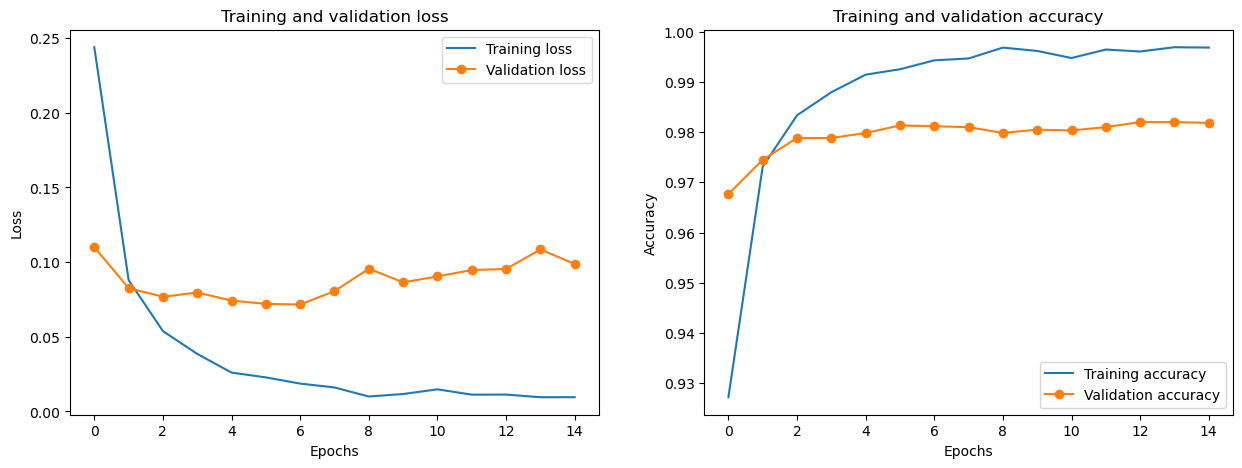

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
epochs_run = [i for i in range(epochs)]

ax1.plot(epochs_run, train_loss, label="Training loss")
ax1.plot(epochs_run, val_loss, label="Validation loss", marker="o")

ax1.set_title("Training and validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(epochs_run, train_acc, label="Training accuracy")
ax2.plot(epochs_run, val_acc, label="Validation accuracy", marker="o")

ax2.set_title("Training and validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

#### 4.2.1. Model prediction

In [115]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0957743376493454
Test accuracy: 0.9811999797821045


In [116]:
y_pred = model.predict(X_test)

In [117]:
np.argmax(y_pred, axis=1)

array([7, 2, 1, ..., 4, 5, 6])

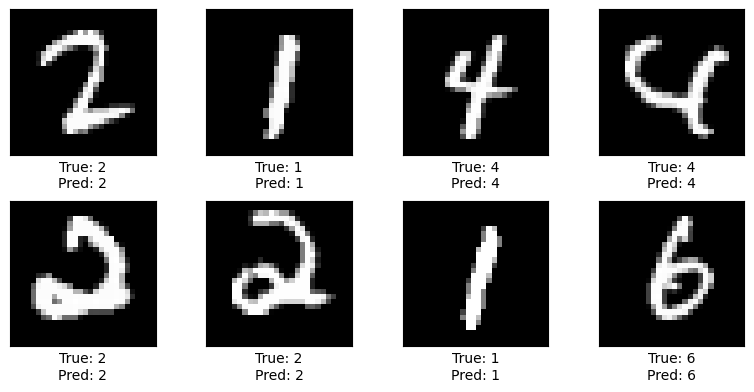

In [118]:
plot_data(X_test, np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))